In [1]:
# load the package
include("../FractionalFlow/FractionalFlow.jl")
using PyPlot, SetPyPlot, NLopt, Dierckx
import Calculus
import GR
FF = FractionalFlow

FractionalFlow

## Note
For the tertiary low salinity water flooding, the recovery factor is calculated by 
$$R_{tert}=\frac{S_{w,avg}-(1-S_{or,hs})}{S_{or,hs}}$$
However, the recovery factor is usually reported as the percentage of the initial oil that is in the reservoir before the secondary formation water water flooding, i.e.,
$$R=\frac{S_{w,avg}-S_{w,init}}{1-S_{w,init}}$$
To convert one to the other, we can write
$$R=\frac{\left(R_{tert}S_{or,hs}+(1-S_{or,hs})\right)-S_{w,init}}{1-S_{w,init}}$$
We can also do it the other way around, i.e.,
$$R_{tert}=\frac{R\left(1-S_{w,init}\right)+S_{w,init}-\left(1-S_{or,hs}\right)}{S_{or,hs}}$$

# Secondary smart-water flooding

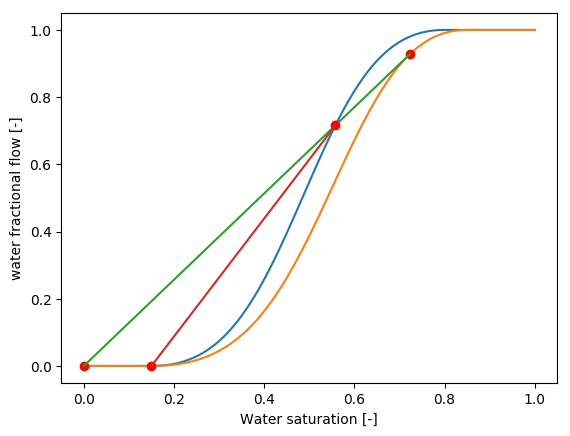

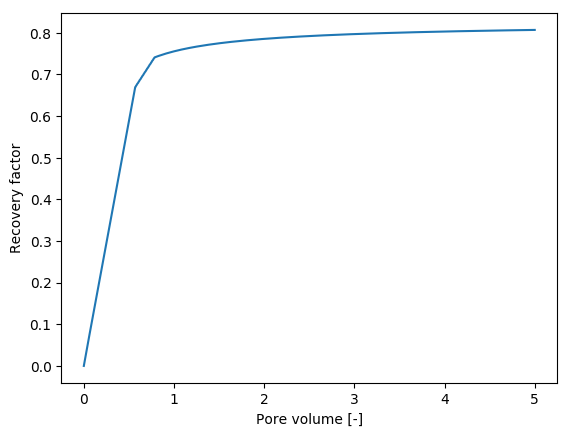

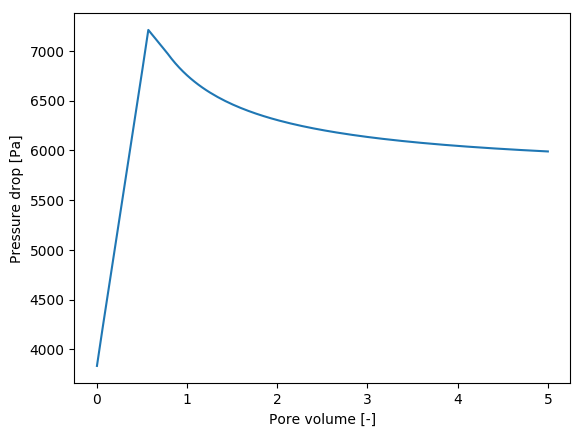

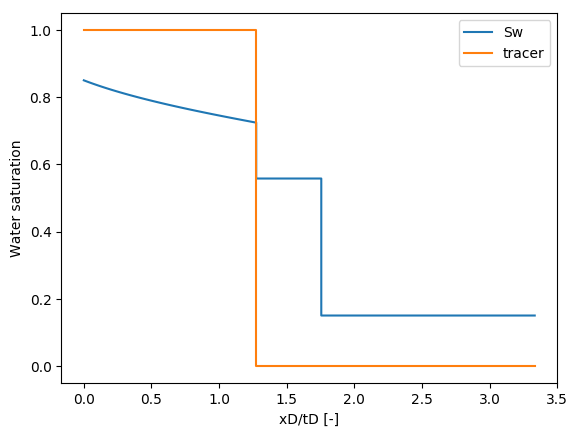

PyObject <matplotlib.legend.Legend object at 0x7fac0cb8bbd0>

In [14]:
# define the problem
sw0 = 0.15 # initial condition of the experiment
sor_hs = 0.2 # high salinity (formation water) residual oil saturation
sw_init = sw0
fluids_hs = FF.oil_water_fluids(mu_water=1e-3, mu_oil=2e-3)
fluids_ls = FF.oil_water_fluids(mu_water=1e-3, mu_oil=2e-3)
rel_perms_hs = FF.oil_water_rel_perms(krw0=0.4, kro0=0.9, 
        swc=0.15, sor=sor_hs, nw=2.0, no = 2.0)
rel_perms_ls = FF.oil_water_rel_perms(krw0=0.3, kro0=0.95, 
        swc=0.15, sor=0.15, nw=2.0, no = 2.0)
core_flood = FF.core_flooding(u_inj=1.15e-5, pv_inject=5.0, p_back=1e5, sw_init=sw_init, 
    sw_inj=1.0, rel_perms=rel_perms_hs)
core_props = FF.core_properties()
wf_res = FF.low_sal_water_flood(core_props, fluids_ls, fluids_hs, rel_perms_hs, 
        rel_perms_ls, core_flood)
FF.visualize(wf_res)

In [11]:
# find((wf_res.saturation_profile_xt[2:end,1]-wf_res.saturation_profile_xt[1:end-1,1]).<=0)

0-element Array{Int64,1}

In [3]:
# t_sec, pv, rec_fact, dp_core, x, sw, c, c_out_sal=
#             FF.water_flood_numeric(core_props, fluids, rel_perms, core_flood)

In [4]:
# figure()
# plot(t_sec, rec_fact, "o", wf_res.recovery_time[:,1], wf_res.recovery_time[:,2])
# figure()
# plot(t_sec, dp_core, "o", wf_res.dp_time[:,1], wf_res.dp_time[:,2])

# synthetic experimental data
Here I scale the calculated recovery data to the total recovery data for a core initially saturated with oil at a saturation close to the connate water saturation, and secondary flooded with formation water.

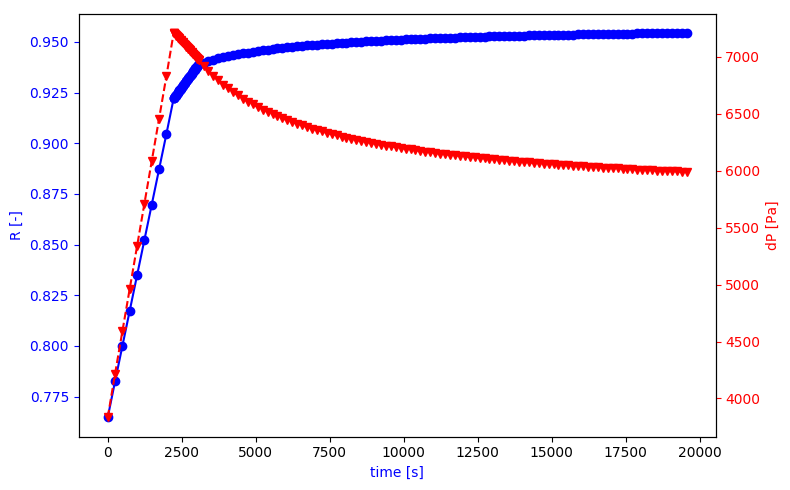

(PyPlot.Figure(PyObject <Figure size 800x500 with 2 Axes>), PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x7fac285f6950>, PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x7fac28d27910>)

In [15]:
R_exp = (wf_res.recovery_time[:,2].*sor_hs+(1-sor_hs)-sw0)./(1-sw0)
t_exp_dp = wf_res.dp_time[:,1]
dp_exp = wf_res.dp_time[:,2]
t_exp_R = wf_res.recovery_time[:,1]
# R_exp = wf_res.recovery_time[:,2]
plotyy(t_exp_R, R_exp, t_exp_dp, dp_exp, fig_size = [8,5], x_label="time [s]", y1_label="R [-]", y2_label="dP [Pa]")

Later, we need to convert the above data back to the tertiary recovery factor, as if the core flooding experiments starts with a core saturated with $S_{or,hs}$ oil saturation.

# define the objective function

In [16]:
# struct
struct exp_data
    t_exp_dp
    dp_exp
    t_exp_R
    R_exp
end

# convert the recovery data
R_conv = (R_exp.*(1-sw0)+sw0-(1-sor_hs))/sor_hs
exp_data1 = exp_data(t_exp_dp, dp_exp, t_exp_R, R_conv)

exp_data(Real[0.0, 247.682, 495.364, 743.046, 990.728, 1238.41, 1486.09, 1733.77, 1981.46, 2229.14  …  18065.7, 18232.3, 18398.9, 18565.5, 18732.1, 18898.8, 19065.4, 19232.0, 19398.6, 19565.2], Real[3833.33, 4216.58, 4589.58, 4962.56, 5335.53, 5708.51, 6081.48, 6454.46, 6827.43, 7210.48  …  6007.71, 6005.49, 6003.31, 6001.17, 5999.07, 5997.0, 5994.97, 5992.96, 5990.99, 5989.06], Real[0.0, 247.682, 495.364, 743.046, 990.728, 1238.41, 1486.09, 1733.77, 1981.46, 2229.14  …  18065.7, 18232.3, 18398.9, 18565.5, 18732.1, 18898.8, 19065.4, 19232.0, 19398.6, 19565.2], [0.0, 0.0757378, 0.149773, 0.22381, 0.297846, 0.371883, 0.44592, 0.519957, 0.593994, 0.669236  …  0.805421, 0.805574, 0.805724, 0.805872, 0.806018, 0.806161, 0.806302, 0.80644, 0.806577, 0.806711])

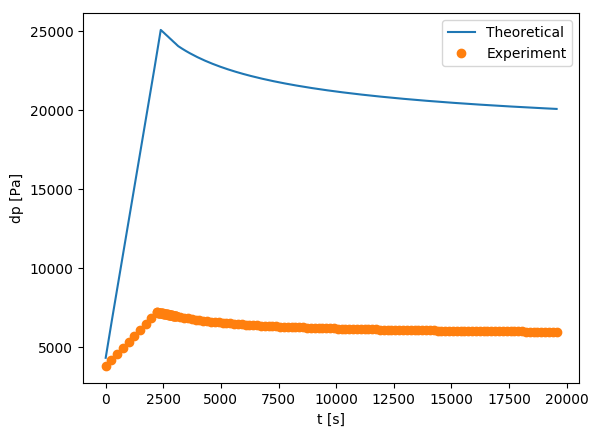

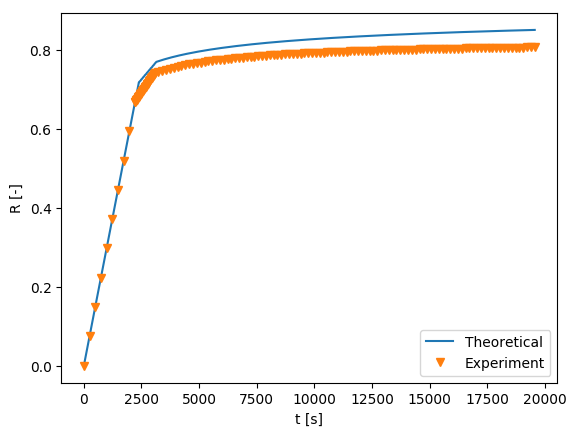

2.384974100844619

In [34]:
"""
rel_perm_param [krw0, kro0, nw, no, swc, sor]
core_props, fluids_ls, fluids_hs, rel_perms_hs, 
        rel_perms_ls, core_flood
"""
function error_calc(rel_perm_param_ls, rel_perm_param_hs, exp_data, core_props, fluids_ls, fluids_hs, 
        core_flood; w_p=1.0, w_R=1.0)
    rel_perms_ls = FF.oil_water_rel_perms(krw0=rel_perm_param_ls[1], kro0=rel_perm_param_ls[2], 
    swc=rel_perm_param_ls[5], sor=rel_perm_param_ls[6], nw=rel_perm_param_ls[3], no = rel_perm_param_ls[4])
    rel_perms_hs = FF.oil_water_rel_perms(krw0=rel_perm_param_hs[1], kro0=rel_perm_param_hs[2], 
    swc=rel_perm_param_hs[5], sor=rel_perm_param_hs[6], nw=rel_perm_param_hs[3], no = rel_perm_param_hs[4])
    wf_res = FF.low_sal_water_flood(core_props, fluids_ls, fluids_hs, rel_perms_hs, 
        rel_perms_ls, core_flood)
    dp_calc = Spline1D(wf_res.dp_time[:,1], wf_res.dp_time[:,2], k=1, bc="nearest")
    R_calc = Spline1D(wf_res.recovery_time[:,1], wf_res.recovery_time[:,2], k=1, bc="nearest")
    error_dp = abs.(dp_calc(exp_data.t_exp_dp) .- exp_data.dp_exp)
#     println(error_dp)
    error_R = abs.(R_calc(exp_data.t_exp_R) .- exp_data.R_exp)
#     println(error_R)
    error_dp_norm = w_p.*error_dp./exp_data.dp_exp
    error_R_norm = w_R.*error_R #./(exp_data.R_exp+eps()) # to avoid division by a small number
    return mean(error_R_norm)+mean(error_dp_norm)
end

function vis_error(rel_perm_param_ls, rel_perm_param_hs, exp_data, core_props, fluids_ls, fluids_hs, 
        core_flood)
    
    rel_perms_ls = FF.oil_water_rel_perms(krw0=rel_perm_param_ls[1], kro0=rel_perm_param_ls[2], 
    swc=rel_perm_param_ls[5], sor=rel_perm_param_ls[6], nw=rel_perm_param_ls[3], no = rel_perm_param_ls[4])
    
    rel_perms_hs = FF.oil_water_rel_perms(krw0=rel_perm_param_hs[1], kro0=rel_perm_param_hs[2], 
    swc=rel_perm_param_hs[5], sor=rel_perm_param_hs[6], nw=rel_perm_param_hs[3], no = rel_perm_param_hs[4])
    
    wf_res = FF.low_sal_water_flood(core_props, fluids_ls, fluids_hs, rel_perms_hs, 
        rel_perms_ls, core_flood)
    figure()
    plot(wf_res.dp_time[:,1], wf_res.dp_time[:,2],  exp_data.t_exp_dp, exp_data.dp_exp, "o")
    xlabel("t [s]")
    ylabel("dp [Pa]")
    legend(["Theoretical", "Experiment"])
    
    figure()
    plot(wf_res.recovery_time[:,1], wf_res.recovery_time[:,2], exp_data.t_exp_R, exp_data.R_exp, "v")
    xlabel("t [s]")
    ylabel("R [-]")
    legend(["Theoretical", "Experiment"])
    
end

# test
x_init = [0.1, 0.7, 2, 3.0, 0.15, 0.07, 0.1, 0.9, 2, 3.0, 0.12, 0.15]

vis_error(x_init[1:6], x_init[7:12], exp_data1, core_props, fluids_ls, fluids_hs, core_flood)
error_calc(x_init[1:6], x_init[7:12], exp_data1, core_props, fluids_ls, fluids_hs, core_flood)

# define the objective function and gradients and weight factors

In [23]:
# weight factors:
w_p = ones(length(exp_data1.dp_exp))
ind_max = indmax(exp_data1.dp_exp)
w_p[ind_max-1:ind_max+2] = 10
w_p[end:end-5]=10
w_p[1]=10
w_R = ones(length(exp_data1.R_exp))
w_R[20:25] = 10
w_R[end:end-5]=10


function f(x)
    f_val = 0.0
    try
        f_val = error_calc(x, exp_data1, core_props, fluids_ls, fluids_hs, 
            core_flood, w_p = w_p, w_R = w_R)
    catch
        f_val = 100.0
#         info("Objective function did not converge!")
    end
    return f_val
end

    
function g(x)
    eps1 = 1e-4
    f_val = f(x)
    g_val = ones(length(x))
    try
        # g_val = Calculus.gradient(x -> error_calc(x, exp_data1, core_props, fluids, core_flood), x)
        for j in eachindex(x)
            x2 = copy(x)
            x2[j]+=eps1
            f_val2 = f(x2)
            g_val[j] = (f_val2-f_val)/eps1
        end
    catch
        g_val = ones(length(x))
    end
    return g_val
end

function obj_fun(param, grad)
    if length(grad)>0
      grad[:] = g(param)
    end
    
    obj_fun_val = f(param)
    if isnan(obj_fun_val) || isinf(obj_fun_val)
        obj_fun_val = 100.0
    end
    return obj_fun_val
end

# test
x_init = [0.1, 0.7, 2, 3.0, 0.15, 0.1, 0.08, 0.9, 2, 3.0, 0.15, 0.15]
grad_x = zeros(12)
obj_fun(x_init, grad_x)

f(x_init)

100.0

In [24]:
grad_x

12-element Array{Float64,1}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [11]:
## algorithms
# L: Local, G:global
# D: derivative-based, N: non-derivative (search-based)

# :LD_MMA
# :LN_COBYLA
# :LD_LBFGS
# :GN_DIRECT
# :GN_DIRECT_L
# GN_CRS2_LM
# G_MLSL_LDS
# GD_STOGO
# GN_ISRES
# GN_ESCH
# LN_NEWUOA_BOUND
# LN_BOBYQA
# LN_PRAXIS
# LN_NELDERMEAD
# LN_SBPLX
# LD_SLSQP
# LD_TNEWTON_PRECOND_RESTART
# LD_TNEWTON_RESTART
# LD_TNEWTON_PRECOND


In [35]:
x_init = [0.1, 0.7, 2, 3.0, 0.15, 0.07, 0.1, 0.9, 2, 3.0, 0.12, 0.15]
x_lb = [0.1, 0.1, 1.5, 1.5, 0.05, 0.05, 0.1, 0.1, 1.5, 1.5, 0.05, 0.11]
x_ub = [1.0, 1.0, 4.0, 4.0, core_flood.initial_water_saturation, 0.1, 1.0, 1.0, 4.0, 4.0, core_flood.initial_water_saturation, 0.25]
opt_alg=:LN_COBYLA
opt1 = Opt(opt_alg, length(x_init)) # choose the algorithm
lower_bounds!(opt1, x_lb)
upper_bounds!(opt1, x_ub)
ftol_rel!(opt1, 1e-15)
ftol_abs!(opt1, 1e-15)

min_objective!(opt1, obj_fun)
(fObjOpt, paramOpt, flag) = optimize(opt1, x_init)

(100.0, [0.1, 0.7, 2.0, 3.0, 0.15, 0.07, 0.1, 0.9, 2.0, 3.0, 0.12, 0.15], :ROUNDOFF_LIMITED)

In [28]:
core_flood.initial_water_saturation

0.15

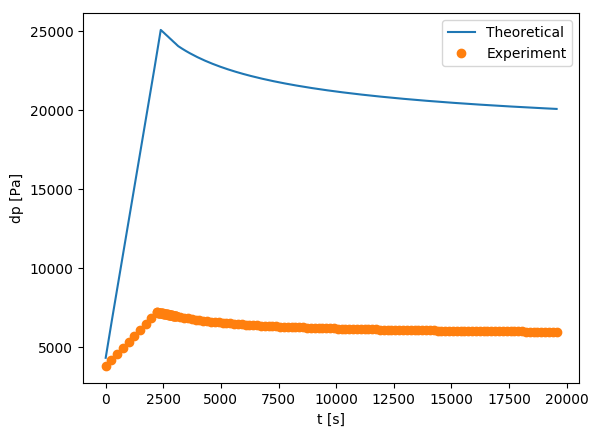

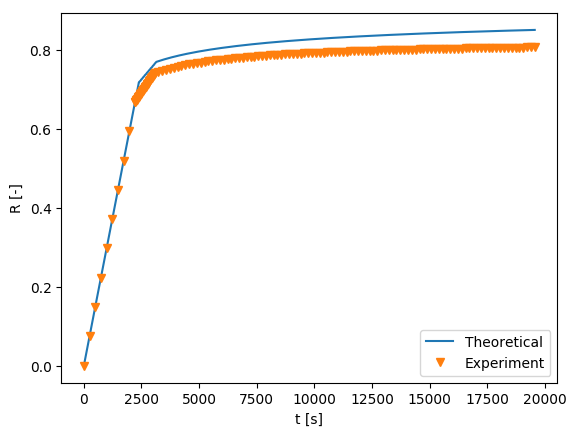

2.384974100844619

In [36]:
x_init = paramOpt
vis_error(x_init[1:6], x_init[7:12], exp_data1, core_props, fluids_ls, fluids_hs, core_flood)
error_calc(x_init[1:6], x_init[7:12], exp_data1, core_props, fluids_ls, fluids_hs, core_flood)

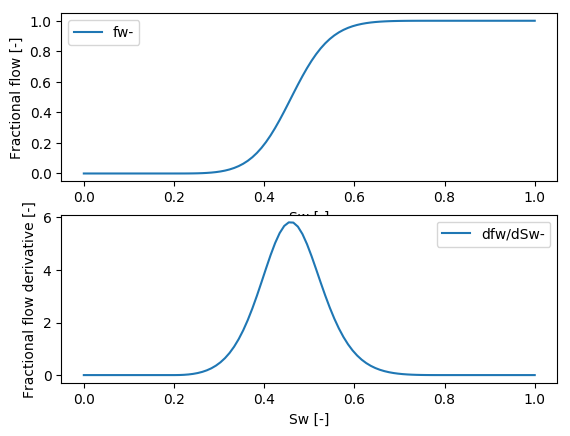

PyObject <matplotlib.legend.Legend object at 0x7f15558edb50>

In [38]:
rel_perm_param=[1.0, 0.8, 3, 4, 0.2, 0.2]
rel_perms2 = FF.oil_water_rel_perms(krw0=rel_perm_param[1], kro0=rel_perm_param[2], 
    swc=rel_perm_param[5], sor=rel_perm_param[6], nw=rel_perm_param[3], no = rel_perm_param[4])
FF.visualize(rel_perms2, fluids)